In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


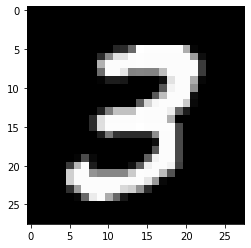

In [5]:
from matplotlib import pyplot as plt

plt.imshow(x_train[7].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [6]:
x_train = torch.tensor(x_train).to(device)
y_train = torch.tensor(y_train).to(device)
x_valid = torch.tensor(x_valid).to(device)
y_valid = torch.tensor(y_valid).to(device)

n, c = x_train.shape

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [7]:
import numpy as np


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):    
    for epoch in range(epochs):
        model.train()
        losses, nums = zip(
            *[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl]
        )
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, train_loss, val_loss)

In [8]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 256, bias=True)
        self.fc2 = nn.Linear(256, 128, bias=True)
        self.fc3 = nn.Linear(128, 64, bias=True)
        self.fc4 = nn.Linear(64, 32, bias=True)
        self.fc5 = nn.Linear(32, 16, bias=True)
        self.fc6 = nn.Linear(16, 10, bias=True)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.relu(self.fc3(X))
        X = self.relu(self.fc4(X))
        X = self.relu(self.fc5(X))
        X = self.fc6(X)
        return X

In [9]:
def get_model():
    model = Neural_Network().to(device)
    return model, optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [10]:
# batch size
bs = 32

# learning rate
lr = 0.01

momentum = 0.9

epochs = 10

loss_func = nn.CrossEntropyLoss()

In [11]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

model, opt = get_model()

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.9142067812442779 0.23860698907375336
1 0.1799691570186615 0.14973343539237977
2 0.11425942454338074 0.13497820529937743
3 0.08616791490793228 0.11732496769428254
4 0.066284990401268 0.11456447353363038
5 0.05600850636959076 0.09323595039844514
6 0.044039564173221586 0.11552084972858429
7 0.037374799010753634 0.11597086539268493
8 0.032606023285388946 0.11722527582645416
9 0.02795169508934021 0.09891575226783753


Test Accuracy: 0.9764
Correct: 9764
Incorrect: 236


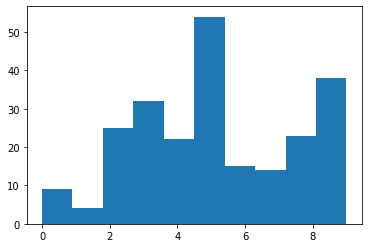

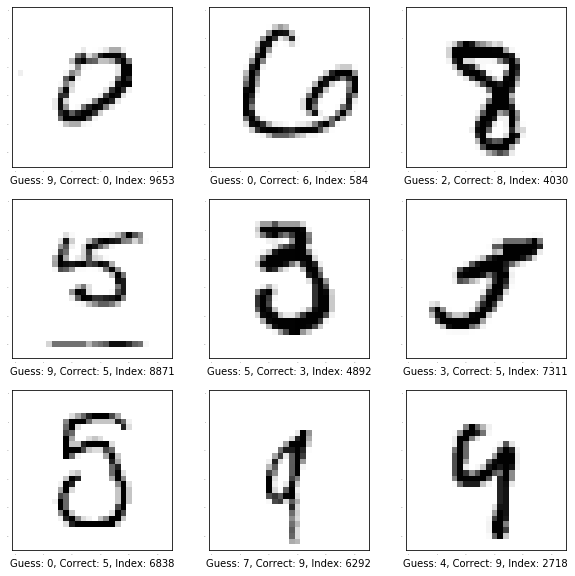

In [12]:
# Eval
model.eval()

with torch.no_grad():
    y_valid_ = model(x_valid)  

correct = []
incorrect = []

num_datapoints = y_valid.shape[0]

for i in range(num_datapoints):
    if y_valid[i] == torch.argmax(y_valid_[i]):
        correct.append(i)
    else:
        incorrect.append(i)
    
print("Test Accuracy:", len(correct) / num_datapoints)
print("Correct:", len(correct))
print("Incorrect:", len(incorrect))

# plot some incorrect testing examples
if len(incorrect) >= 9:
    
    x_train = x_train.cpu()
    x_valid = x_valid.cpu()
    y_train = y_train.cpu()
    y_valid = y_valid.cpu()
    
    
    x_incorrect = x_valid[incorrect]
    y_incorrect = model.forward(x_incorrect.to(device))
    incorrect_labels = torch.argmax(y_incorrect, 1)
    correct_labels = y_valid[incorrect]
    
    correct_digits = [y_valid[i] for i in incorrect]
    plt.hist(correct_digits, label="Misclassifications by Digit")

    from random import sample
    
    examples = sample(range(len(incorrect)), 9)

    plt.figure(figsize=(10,10))
    for i in range(9):
        index = examples[i]
        plt.subplot(3,3,i+1)
        plt.tick_params(axis='both', labelsize=0, length=0)
        plt.grid(False)
        plt.imshow(x_incorrect[index].reshape((28,28)), cmap='Greys')
        label = f"Guess: {incorrect_labels[index]}, Correct: {correct_labels[index]}, Index: {incorrect[index]}"
        plt.xlabel(label)
    plt.show()